In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import os
datapath = "../../../../../datasets/COVID-CTsets/COVID-CTset-part1/dataset"
print(os.path.exists(datapath))

True


In [3]:
image_dims = (224, 224)
batch_size = 16
if (os.path.exists(datapath)==True):
    train_datagen = ImageDataGenerator(rescale = 1./255, 
                                      vertical_flip=True,
                                      rotation_range = 5,
                                      zoom_range=0.2
                                        )
    test_datagen = ImageDataGenerator(rescale = 1./255)
    validation_datagen = ImageDataGenerator(rescale = 1./255)
    train_generator = train_datagen.flow_from_directory(os.path.join(datapath, "train"),
                                                 target_size = image_dims,
                                                batch_size = 16,
                                                 class_mode = 'categorical',
                                                color_mode = 'rgb',
                                               shuffle=True,
                                                       seed=10)
    test_generator = test_datagen.flow_from_directory(os.path.join(datapath, "test"), 
                                                                 target_size = image_dims,
                                                                  batch_size = 16,
                                                                 class_mode = 'categorical', 
                                                                 color_mode = 'rgb',
                                                                 shuffle=False,
                                                                 seed=10)
    valid_generator = validation_datagen.flow_from_directory(os.path.join(datapath, "valid"), 
                                                         target_size = image_dims,
                                                          batch_size = 16,
                                                         class_mode = 'categorical', 
                                                         color_mode = 'rgb',
                                                         shuffle=False,
                                                         seed=10)

Found 5842 images belonging to 2 classes.
Found 1947 images belonging to 2 classes.
Found 1948 images belonging to 2 classes.


In [4]:
x_train, y_train = next(train_generator)
x_valid, y_valid = next(valid_generator)
x_test, y_test = next(test_generator)

In [5]:
print(x_train.shape)

(16, 224, 224, 3)


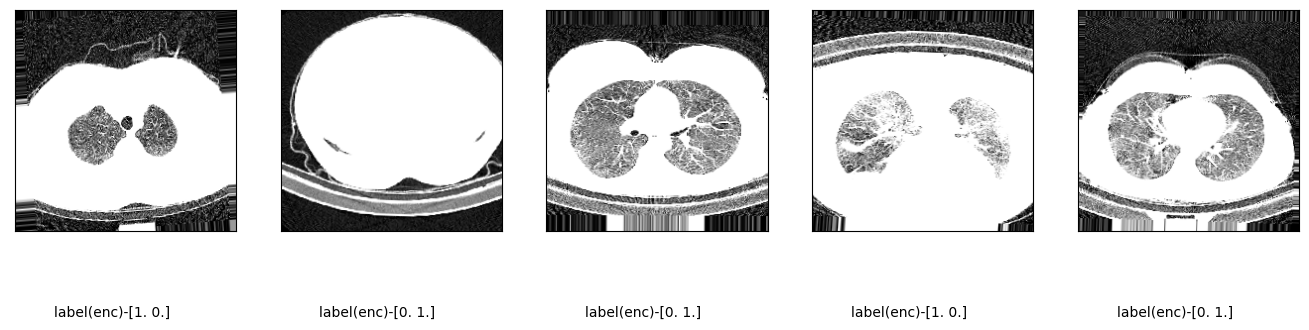

In [6]:
import matplotlib.pyplot as plt
n = 6
plt.figure(figsize=(20, 4))

for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i], cmap='gray')
    ax.text(0.7, -0.4, "label(enc)-{0}".format(y_train[i]),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=10)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
# import matplotlib.pyplot as plt
def plot_accuracy_and_loss(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '--r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, '--r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [8]:
import tensorflow as tf

In [9]:
vgg_model = tf.keras.applications.VGG19(weights='imagenet',
                                      include_top=False,
                                        input_shape=(224, 224, 3))
# vgg_model.summary()
vgg_model.trainable=False 

x = vgg_model.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
vgg_output = tf.keras.layers.Dense(2, activation='softmax')(x)

vgg = tf.keras.models.Model(vgg_model.input, vgg_output)
vgg._name='vgg19'
# vgg.summary()

In [11]:
# model_checkpoint_path = path + '/models/test1/vgg'
## callback
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#                                                     filepath=model_checkpoint_path,
#                                                     save_weights_only=False,
#                                                     monitor='val_loss',
#                                                     mode='min',
#                                                     save_best_only=False,
#                                                     save_frequency= epoch)

In [12]:
vgg.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

vgg_history = vgg.fit(train_generator,
                    epochs=1,
                    validation_data=valid_generator,
                    steps_per_epoch = 366,
                     use_multiprocessing=True)
# 5842 / 16 = 365.125 ~ 366  

# vgg.save(model_checkpoint_path)

366/366 [==============================] - 643s 2s/step - loss: 1.0409 - binary_accuracy: 0.5339 - val_loss: 0.6720 - val_binary_accuracy: 0.5934


In [13]:
# plot_accuracy_and_loss(vgg_history)

In [14]:
# test_loss, test_acc = vgg.evaluate(test_generator)
# print('Accuracy:', test_acc)
# print('Loss: ', test_loss)

In [15]:
dense169_model = tf.keras.applications.DenseNet169(weights='imagenet',
                                      include_top=False,
                                        input_shape=(224, 224, 3)
                                      )
# dense169_model.summary()
dense169_model.trainable=False 

y = dense169_model.layers[-1].output
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(1000, activation='relu')(y)
y = tf.keras.layers.Dropout(0.5)(y)
densenet_1_output = tf.keras.layers.Dense(2, activation='softmax')(y)

densenet_1 = tf.keras.models.Model(dense169_model.input, densenet_1_output)
densenet_1._name='densenet_1'
# densenet_1.summary()

In [16]:
# model_checkpoint_path = path + '/models/test1/densenet-output2'
# ## callback
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#                                                     filepath=model_checkpoint_path,
#                                                     save_weights_only=False,
#                                                     monitor='val_loss',
#                                                     mode='min',
#                                                     save_best_only=True)

In [17]:
densenet_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

densenet_1_history = densenet_1.fit(train_generator,
                    epochs=1,
                    validation_data=valid_generator)

# densenet_1.save(model_checkpoint_path)

366/366 [==============================] - 556s 1s/step - loss: 2.4720 - binary_accuracy: 0.6296 - val_loss: 0.6313 - val_binary_accuracy: 0.6786


In [18]:
# plot_accuracy_and_loss(densenet_1_history)

In [19]:
# test_loss, test_acc = densenet_1.evaluate(test_generator)
# print('Accuracy:', test_acc)
# print('Loss: ', test_loss)

In [20]:
dense169_model2 = tf.keras.applications.DenseNet169(weights='imagenet',
                                      include_top=False,
                                        input_shape=(224, 224, 3)
                                      )
# dense169_model.summary()
dense169_model2.trainable=False 
# since the model is already loaded we load in again
z = dense169_model2.layers[-1].output
z = tf.keras.layers.Flatten()(z)
z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(1000, activation='relu')(z)
z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(500, activation='relu')(z)
z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(200, activation='relu')(z)
z = tf.keras.layers.Dropout(0.5)(z)
densenet_2_output = tf.keras.layers.Dense(2, activation='softmax')(z)

densenet_2 = tf.keras.models.Model(dense169_model2.input, densenet_2_output)
densenet_2._name='densenet_2'
# densenet_2.summary()

In [21]:
# model_checkpoint_path = path + '/models/test1/densenet-output3'
# ## callback
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#                                                     filepath=model_checkpoint_path,
#                                                     save_weights_only=False,
#                                                     monitor='val_loss',
#                                                     mode='min',
#                                                     save_best_only=True)

In [22]:
densenet_2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

densenet_2_history = densenet_2.fit(train_generator,
                    epochs=1,
                    validation_data=valid_generator)

# densenet_2.save(model_checkpoint_path)

366/366 [==============================] - 692s 2s/step - loss: 2.7452 - binary_accuracy: 0.5425 - val_loss: 0.6749 - val_binary_accuracy: 0.6463


In [23]:
# plot_accuracy_and_loss(densenet_2_history)

In [24]:
# test_loss, test_acc = densenet_2.evaluate(X_test_original, y_test_cat)
# print('Accuracy:', test_acc)
# print('Loss: ', test_loss)

In [25]:
# vgg = tf.keras.models.load_model(path+'/models/test1/vgg')
# densenet_1 = tf.keras.models.load_model(path+'/models/test1/densenet-output2')
# densenet_2 = tf.keras.models.load_model(path+'/models/test1/densenet-output3')

In [26]:
vgg.trainable = False
densenet_1.trainable = False
densenet_2.trainable = False
models = [vgg, densenet_1, densenet_2]
# to avoid conflicts with naming
for layer in models[0].layers:
    layer._name = layer.name + str('_0')
for layer in models[1].layers:
    layer._name = layer.name + str('_1')
for layer in models[2].layers:
    layer._name = layer.name + str('_2')

In [27]:
average = tf.keras.layers.Average()([vgg.output, densenet_1.output, densenet_2.output])
dense = tf.keras.layers.Dense(1, activation='sigmoid')(average)

ensemble = tf.keras.Model([vgg.input, densenet_1.input, densenet_2.input], dense)

In [28]:
# ensemble.summary()

In [29]:
ensemble.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [30]:
# model_checkpoint_path = path + '/models/test1/ensemble'
# ## callback
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#                                                     filepath=model_checkpoint_path,
#                                                     save_weights_only=False,
#                                                     monitor='val_loss',
#                                                     mode='min',
#                                                     save_best_only=True)

### preparing data for ensemble

In [31]:
def generate_generator_multiple(generator,dir1, batch_size, img_dims):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = img_dims,
                                          class_mode = 'binary',
                                          color_mode='rgb',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    
    genX2 = generator.flow_from_directory(dir1,
                                          target_size = img_dims,
                                          class_mode = 'binary',
                                          color_mode = 'rgb',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    genX3 = generator.flow_from_directory(dir1,
                                          target_size = img_dims,
                                          class_mode = 'binary',
                                          color_mode = 'rgb',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            yield [X1i[0], X2i[0], X3i[0]], X3i[1]  #Yield both images and their mutual label
            
train_gen = ImageDataGenerator(rescale = 1./255, 
                                      vertical_flip=True,
                                      rotation_range = 5,
                                      zoom_range=0.2
                                        )
test_gen = ImageDataGenerator(rescale = 1./255)
valid_gen = ImageDataGenerator(rescale = 1./255)

ensemble_train_generator = generate_generator_multiple(generator=train_gen,
                                             dir1=os.path.join(datapath, "train"),
                                             batch_size=batch_size,
                                                img_dims=image_dims)

ensemble_valid_generator = generate_generator_multiple(generator=valid_gen,
                                             dir1=os.path.join(datapath, "valid"),
                                             batch_size=batch_size,
                                                      img_dims=image_dims)

ensemble_test_generator = generate_generator_multiple(generator=test_gen,
                                             dir1=os.path.join(datapath, "test"),
                                             batch_size=batch_size,
                                                      img_dims=image_dims)

In [32]:
ensemble_history = ensemble.fit(ensemble_train_generator,
                                epochs=1,
                                steps_per_epoch=366,
                               validation_data = ensemble_valid_generator)
# ensemble.save(model_checkpoint_path)

Found 5842 images belonging to 2 classes.
Found 5842 images belonging to 2 classes.
Found 5842 images belonging to 2 classes.


ResourceExhaustedError:  OOM when allocating tensor with shape[16,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_3/block1_conv2_0/Relu
 (defined at /usr/local/lib/python3.8/dist-packages/keras/backend.py:4867)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_93091]

Errors may have originated from an input operation.
Input Source operations connected to node model_3/block1_conv2_0/Relu:
In[0] model_3/block1_conv2_0/BiasAdd (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/convolutional.py:264)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 505, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
>>>     yield self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 250, in wrapper
>>>     runner = Runner(ctx_run, result, future, yielded)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 741, in __init__
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 540, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-32-4eb909ca1d0d>", line 1, in <module>
>>>     ensemble_history = ensemble.fit(ensemble_train_generator,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional.py", line 273, in call
>>>     return self.activation(outputs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/activations.py", line 311, in relu
>>>     return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 4867, in relu
>>>     x = tf.nn.relu(x)
>>> 

In [ ]:
# plot_accuracy_and_loss(ensemble_history)

In [ ]:
# test_loss, test_acc = ensemble.evaluate(ensem)
# print('Accuracy:', test_acc)
# print('Loss: ', test_loss)

In [ ]:
# ensemble = tf.keras.models.load_model(path + "/models/test1/ensemble")

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(ensemble, to_file = path + '/models/test1/ensemble.png', dpi=50)

In [ ]:
performance_test_generator = generate_generator_multiple(generator=test_gen,
                                             dir1=os.path.join(datapath, "test"),
                                             batch_size=400,
                                           img_dims=img_dims)

In [ ]:
x, y = next(performance_test_generator)

In [ ]:
y_pred = ensemble.predict(x)

In [ ]:
y_pred[y_pred > 0.6] = 1.0
y_pred[y_pred <= 0.6] = 0.0

print(y_pred.shape)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import recall_score ,precision_score,accuracy_score, f1_score,roc_auc_score

In [ ]:
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result

In [ ]:
result6 = binary_classification_performance(y, y_pred)
display(result6)

In [ ]:
y_pred = ensemble.predict(x)
y_pred[y_pred > 0.1] = 1.0
y_pred[y_pred <= 0.1] = 0.0
print("threshold - 0.1")
result1 = binary_classification_performance(y, y_pred)
display(result1)

In [ ]:
y_pred = ensemble.predict(x)
y_pred[y_pred > 0.2] = 1.0
y_pred[y_pred <= 0.2] = 0.0
print("threshold - 0.2")
result1 = binary_classification_performance(y, y_pred)
display(result1)

In [ ]:
y_pred = ensemble.predict(x)
y_pred[y_pred > 0.3] = 1.0
y_pred[y_pred <= 0.3] = 0.0
print("threshold - 0.1")
result1 = binary_classification_performance(y, y_pred)
display(result1)

In [ ]:
y_pred = ensemble.predict(x)
y_pred[y_pred > 0.4] = 1.0
y_pred[y_pred <= 0.4] = 0.0
print("threshold - 0.4")
result4 = binary_classification_performance(y, y_pred)
display(result4)

In [ ]:
y_pred = ensemble.predict(x)
y_pred[y_pred > 0.5] = 1.0
y_pred[y_pred <= 0.5] = 0.0
print("threshold - 0.5")
result5 = binary_classification_performance(y, y_pred)
display(result5)

In [ ]:
y_pred = ensemble.predict(x)
y_pred[y_pred > 0.7] = 1.0
y_pred[y_pred <= 0.7] = 0.0
print("threshold - 0.7")
result7 = binary_classification_performance(y, y_pred)
display(result7)

In [ ]:
y_pred = ensemble.predict(x)
y_pred[y_pred > 0.8] = 1.0
y_pred[y_pred <= 0.8] = 0.0
print("threshold - 0.8")
result8 = binary_classification_performance(y, y_pred)
display(result8)

In [ ]:
y_pred = ensemble.predict(x)
y_pred[y_pred > 0.9] = 1.0
y_pred[y_pred <= 0.9] = 0.0
print("threshold - 0.9")
result9 = binary_classification_performance(y_test_enc, y_pred)
display(result9)

In [ ]:
results = [result1, result2, result3, result4, result5, result6, result7, result8, result9 ]

In [ ]:
accuracies = [i['Accuracy'] for i in results ]
recalls = [i['Recall (senitivity or TPR)'] for i in results ]
precisions = [i['Precision (or PPV)'] for i in results ]
f1s = [i['f1 score'] for i in results ]

In [ ]:
X = np.linspace(0.1, 0.9, 9)
plt.plot(X, accuracies, label="accuracy")
plt.plot(X, recalls, label='recall')
plt.plot(X, precisions, label='precision')
plt.plot(X, f1s, label='f1 score')
plt.legend()
plt.show()

In [ ]:
results = pd.concat(results)

In [ ]:
results.insert(0, "Threshold", X, True)
results = results.reset_index(drop=True)

pd.set_option('precision', 3)

In [ ]:
results.style.highlight_max(color = 'black')